# Trains a diffusion model on CIFAR-10 (version 4).

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings).

The model is a denoising diffusion probabilistic model (https://arxiv.org/abs/2006.11239), which is trained to reverse a gradual noising process, allowing the model to generate samples from the learned data distribution starting from random noise. DDIM-style deterministic sampling (https://arxiv.org/abs/2010.02502) is also supported. This model is also trained on continuous timesteps. It uses the 'v' objective from Progressive Distillation for Fast Sampling of Diffusion Models (https://openreview.net/forum?id=TIdIXIpzhoI). It is usable for classifier-free diffusion guidance (https://openreview.net/forum?id=qw8AKxfYbI).

In [11]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [12]:
# Check the GPU type

!nvidia-smi

Tue Jun  7 19:44:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:07:00.0 Off |                    0 |
| N/A   51C    P0   108W / 400W |  31777MiB / 40537MiB |     83%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [13]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [14]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [15]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, is_last=False):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if not is_last else nn.Identity(),
            nn.ReLU(inplace=True) if not is_last else nn.Identity(),
        ], skip)


class SelfAttention2d(nn.Module):
    def __init__(self, c_in, n_head=1, dropout_rate=0.1):
        super().__init__()
        assert c_in % n_head == 0
        self.norm = nn.GroupNorm(1, c_in)
        self.n_head = n_head
        self.qkv_proj = nn.Conv2d(c_in, c_in * 3, 1)
        self.out_proj = nn.Conv2d(c_in, c_in, 1)
        self.dropout = nn.Dropout2d(dropout_rate, inplace=True)

    def forward(self, input):
        n, c, h, w = input.shape
        qkv = self.qkv_proj(self.norm(input))
        qkv = qkv.view([n, self.n_head * 3, c // self.n_head, h * w]).transpose(2, 3)
        q, k, v = qkv.chunk(3, dim=1)
        scale = k.shape[3]**-0.25
        att = ((q * scale) @ (k.transpose(2, 3) * scale)).softmax(3)
        y = (att @ v).transpose(2, 3).contiguous().view([n, c, h, w])
        return input + self.dropout(self.out_proj(y))


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)
        self.class_embed = nn.Embedding(11, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c), 
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        SelfAttention2d(c * 4, c * 4 // 64),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    SelfAttention2d(c * 2, c * 2 // 64),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, is_last=True),
        )

    def forward(self, input, t, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond + 1), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1)) # 这里的方法是直接concat feature map的通道，而不是直接加。


In [16]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@torch.no_grad()
def sample(model, x, steps, eta, classes, guidance_scale=1.):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            x_in = torch.cat([x, x])
            ts_in = torch.cat([ts, ts])
            classes_in = torch.cat([-torch.ones_like(classes), classes])
            v_uncond, v_cond = model(x_in, ts_in * t[i], classes_in).float().chunk(2)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


The noise schedule:


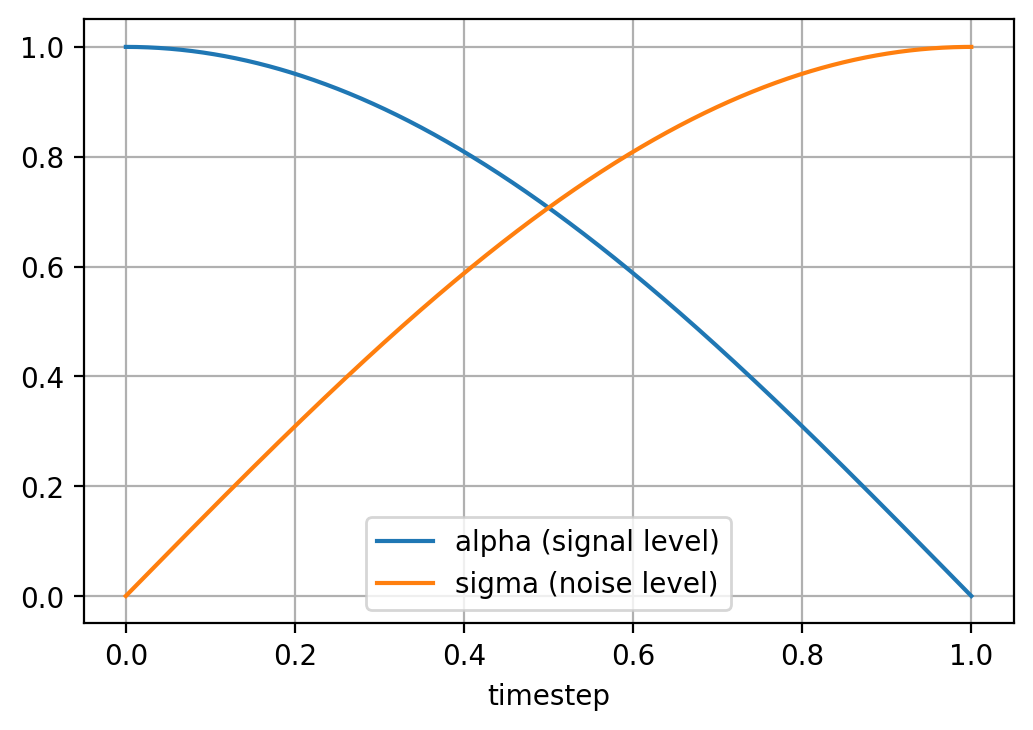

In [17]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
alphas_vis, sigmas_vis = get_alphas_sigmas(t_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [18]:
# Prepare the dataset

batch_size = 100

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.CIFAR10('data', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=True)
val_set = datasets.CIFAR10('data', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [19]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 27487287



Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 0, loss: 0.646127

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

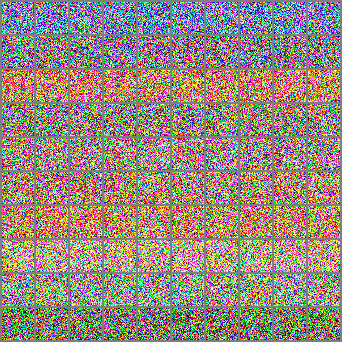


Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.641108
Epoch: 0, iteration: 50, loss: 0.335303
Epoch: 0, iteration: 100, loss: 0.218631
Epoch: 0, iteration: 150, loss: 0.204105
Epoch: 0, iteration: 200, loss: 0.191364
Epoch: 0, iteration: 250, loss: 0.187021
Epoch: 0, iteration: 300, loss: 0.184123
Epoch: 0, iteration: 350, loss: 0.187835
Epoch: 0, iteration: 400, loss: 0.176929
Epoch: 0, iteration: 450, loss: 0.178546
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.167732
Epoch: 1, iteration: 50, loss: 0.165802
Epoch: 1, iteration: 100, loss: 0.161018
Epoch: 1, iteration: 150, loss: 0.169258
Epoch: 1, iteration: 200, loss: 0.16775
Epoch: 1, iteration: 250, loss: 0.159238
Epoch: 1, iteration: 300, loss: 0.157696
Epoch: 1, iteration: 350, loss: 0.147232
Epoch: 1, iteration: 400, loss: 0.154395
Epoch: 1, iteration: 450, loss: 0.153736
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.141698
Epoch: 2, iteration: 50, loss: 0.157262
Epoch: 2, iteration: 100, loss: 0.151823
Epoch: 2, iteration: 150, loss: 0.154334
Epoch: 2, iteration: 200, loss: 0.146387
Epoch: 2, iteration: 250, loss: 0.148434
Epoch: 2, iteration: 300, loss: 0.140086
Epoch: 2, iteration: 350, loss: 0.153188
Epoch: 2, iteration: 400, loss: 0.143489
Epoch: 2, iteration: 450, loss: 0.142238
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.148079
Epoch: 3, iteration: 50, loss: 0.147949
Epoch: 3, iteration: 100, loss: 0.138155
Epoch: 3, iteration: 150, loss: 0.134708
Epoch: 3, iteration: 200, loss: 0.136581
Epoch: 3, iteration: 250, loss: 0.138988
Epoch: 3, iteration: 300, loss: 0.137415
Epoch: 3, iteration: 350, loss: 0.15235
Epoch: 3, iteration: 400, loss: 0.142417
Epoch: 3, iteration: 450, loss: 0.146157
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.144875
Epoch: 4, iteration: 50, loss: 0.130517
Epoch: 4, iteration: 100, loss: 0.143517
Epoch: 4, iteration: 150, loss: 0.144122
Epoch: 4, iteration: 200, loss: 0.139738
Epoch: 4, iteration: 250, loss: 0.143855
Epoch: 4, iteration: 300, loss: 0.154607
Epoch: 4, iteration: 350, loss: 0.140734
Epoch: 4, iteration: 400, loss: 0.141099
Epoch: 4, iteration: 450, loss: 0.126629

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 5, loss: 0.128493

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

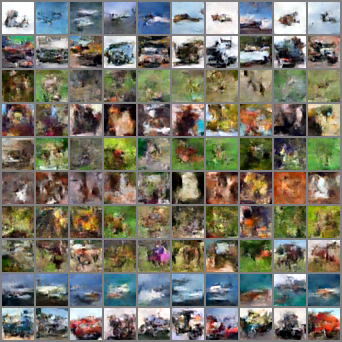


Epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.133008
Epoch: 5, iteration: 50, loss: 0.13377
Epoch: 5, iteration: 100, loss: 0.131559
Epoch: 5, iteration: 150, loss: 0.152723
Epoch: 5, iteration: 200, loss: 0.147361
Epoch: 5, iteration: 250, loss: 0.136497
Epoch: 5, iteration: 300, loss: 0.127027
Epoch: 5, iteration: 350, loss: 0.135605
Epoch: 5, iteration: 400, loss: 0.135238
Epoch: 5, iteration: 450, loss: 0.1391
Epoch 6


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.133706
Epoch: 6, iteration: 50, loss: 0.138304
Epoch: 6, iteration: 100, loss: 0.134243
Epoch: 6, iteration: 150, loss: 0.139473
Epoch: 6, iteration: 200, loss: 0.122505
Epoch: 6, iteration: 250, loss: 0.1286
Epoch: 6, iteration: 300, loss: 0.117093
Epoch: 6, iteration: 350, loss: 0.130984
Epoch: 6, iteration: 400, loss: 0.148209
Epoch: 6, iteration: 450, loss: 0.131956
Epoch 7


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.144916
Epoch: 7, iteration: 50, loss: 0.147231
Epoch: 7, iteration: 100, loss: 0.130435
Epoch: 7, iteration: 150, loss: 0.129448
Epoch: 7, iteration: 200, loss: 0.130296
Epoch: 7, iteration: 250, loss: 0.132371
Epoch: 7, iteration: 300, loss: 0.131092
Epoch: 7, iteration: 350, loss: 0.129326
Epoch: 7, iteration: 400, loss: 0.134744
Epoch: 7, iteration: 450, loss: 0.14061
Epoch 8


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.127301
Epoch: 8, iteration: 50, loss: 0.12981
Epoch: 8, iteration: 100, loss: 0.117746
Epoch: 8, iteration: 150, loss: 0.128783
Epoch: 8, iteration: 200, loss: 0.123301
Epoch: 8, iteration: 250, loss: 0.131834
Epoch: 8, iteration: 300, loss: 0.128332
Epoch: 8, iteration: 350, loss: 0.147336
Epoch: 8, iteration: 400, loss: 0.126888
Epoch: 8, iteration: 450, loss: 0.129556
Epoch 9


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.12259
Epoch: 9, iteration: 50, loss: 0.129238
Epoch: 9, iteration: 100, loss: 0.126629
Epoch: 9, iteration: 150, loss: 0.143302
Epoch: 9, iteration: 200, loss: 0.127471
Epoch: 9, iteration: 250, loss: 0.142098
Epoch: 9, iteration: 300, loss: 0.130613
Epoch: 9, iteration: 350, loss: 0.117367
Epoch: 9, iteration: 400, loss: 0.123029
Epoch: 9, iteration: 450, loss: 0.134476

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.123098

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

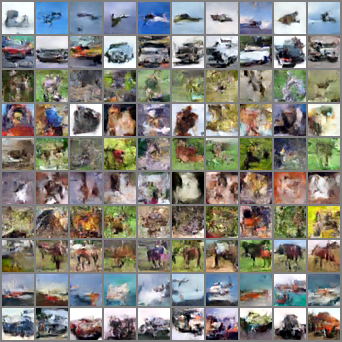


Epoch 10


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10, iteration: 0, loss: 0.120617
Epoch: 10, iteration: 50, loss: 0.125262
Epoch: 10, iteration: 100, loss: 0.139173
Epoch: 10, iteration: 150, loss: 0.131352
Epoch: 10, iteration: 200, loss: 0.138771
Epoch: 10, iteration: 250, loss: 0.127554
Epoch: 10, iteration: 300, loss: 0.132744
Epoch: 10, iteration: 350, loss: 0.133302
Epoch: 10, iteration: 400, loss: 0.128684
Epoch: 10, iteration: 450, loss: 0.13584
Epoch 11


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11, iteration: 0, loss: 0.131655
Epoch: 11, iteration: 50, loss: 0.123029
Epoch: 11, iteration: 100, loss: 0.137943
Epoch: 11, iteration: 150, loss: 0.138339
Epoch: 11, iteration: 200, loss: 0.12415
Epoch: 11, iteration: 250, loss: 0.126812
Epoch: 11, iteration: 300, loss: 0.1192
Epoch: 11, iteration: 350, loss: 0.14542
Epoch: 11, iteration: 400, loss: 0.12875
Epoch: 11, iteration: 450, loss: 0.133108
Epoch 12


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12, iteration: 0, loss: 0.127217
Epoch: 12, iteration: 50, loss: 0.134678
Epoch: 12, iteration: 100, loss: 0.118799
Epoch: 12, iteration: 150, loss: 0.129457
Epoch: 12, iteration: 200, loss: 0.133404
Epoch: 12, iteration: 250, loss: 0.128092
Epoch: 12, iteration: 300, loss: 0.129296
Epoch: 12, iteration: 350, loss: 0.139237
Epoch: 12, iteration: 400, loss: 0.125023
Epoch: 12, iteration: 450, loss: 0.126476
Epoch 13


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13, iteration: 0, loss: 0.125826
Epoch: 13, iteration: 50, loss: 0.12494
Epoch: 13, iteration: 100, loss: 0.131661
Epoch: 13, iteration: 150, loss: 0.121113
Epoch: 13, iteration: 200, loss: 0.127558
Epoch: 13, iteration: 250, loss: 0.135571
Epoch: 13, iteration: 300, loss: 0.135014
Epoch: 13, iteration: 350, loss: 0.123429
Epoch: 13, iteration: 400, loss: 0.122672
Epoch: 13, iteration: 450, loss: 0.128609
Epoch 14


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14, iteration: 0, loss: 0.127757
Epoch: 14, iteration: 50, loss: 0.130598
Epoch: 14, iteration: 100, loss: 0.131784
Epoch: 14, iteration: 150, loss: 0.129652
Epoch: 14, iteration: 200, loss: 0.134403
Epoch: 14, iteration: 250, loss: 0.121928
Epoch: 14, iteration: 300, loss: 0.122633
Epoch: 14, iteration: 350, loss: 0.124095
Epoch: 14, iteration: 400, loss: 0.127451
Epoch: 14, iteration: 450, loss: 0.136471

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 15, loss: 0.120513

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

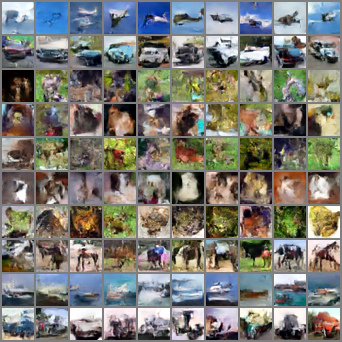


Epoch 15


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15, iteration: 0, loss: 0.128302
Epoch: 15, iteration: 50, loss: 0.122543
Epoch: 15, iteration: 100, loss: 0.120107
Epoch: 15, iteration: 150, loss: 0.119654
Epoch: 15, iteration: 200, loss: 0.123781
Epoch: 15, iteration: 250, loss: 0.136127
Epoch: 15, iteration: 300, loss: 0.120564
Epoch: 15, iteration: 350, loss: 0.13208
Epoch: 15, iteration: 400, loss: 0.122405
Epoch: 15, iteration: 450, loss: 0.132258
Epoch 16


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16, iteration: 0, loss: 0.122179
Epoch: 16, iteration: 50, loss: 0.119858
Epoch: 16, iteration: 100, loss: 0.128613
Epoch: 16, iteration: 150, loss: 0.127998
Epoch: 16, iteration: 200, loss: 0.125507
Epoch: 16, iteration: 250, loss: 0.123594
Epoch: 16, iteration: 300, loss: 0.129438
Epoch: 16, iteration: 350, loss: 0.129969
Epoch: 16, iteration: 400, loss: 0.12049
Epoch: 16, iteration: 450, loss: 0.129442
Epoch 17


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17, iteration: 0, loss: 0.129483
Epoch: 17, iteration: 50, loss: 0.129828
Epoch: 17, iteration: 100, loss: 0.128986
Epoch: 17, iteration: 150, loss: 0.125048
Epoch: 17, iteration: 200, loss: 0.13671
Epoch: 17, iteration: 250, loss: 0.121557
Epoch: 17, iteration: 300, loss: 0.121519
Epoch: 17, iteration: 350, loss: 0.113857
Epoch: 17, iteration: 400, loss: 0.126402
Epoch: 17, iteration: 450, loss: 0.135423
Epoch 18


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18, iteration: 0, loss: 0.117286
Epoch: 18, iteration: 50, loss: 0.131115
Epoch: 18, iteration: 100, loss: 0.132364
Epoch: 18, iteration: 150, loss: 0.140144
Epoch: 18, iteration: 200, loss: 0.116052
Epoch: 18, iteration: 250, loss: 0.120965
Epoch: 18, iteration: 300, loss: 0.120513
Epoch: 18, iteration: 350, loss: 0.126896
Epoch: 18, iteration: 400, loss: 0.125437
Epoch: 18, iteration: 450, loss: 0.136699
Epoch 19


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19, iteration: 0, loss: 0.131401
Epoch: 19, iteration: 50, loss: 0.126615
Epoch: 19, iteration: 100, loss: 0.113745
Epoch: 19, iteration: 150, loss: 0.113265
Epoch: 19, iteration: 200, loss: 0.126678
Epoch: 19, iteration: 250, loss: 0.12444
Epoch: 19, iteration: 300, loss: 0.132801
Epoch: 19, iteration: 350, loss: 0.131466
Epoch: 19, iteration: 400, loss: 0.123117
Epoch: 19, iteration: 450, loss: 0.132592

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 20, loss: 0.119106

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

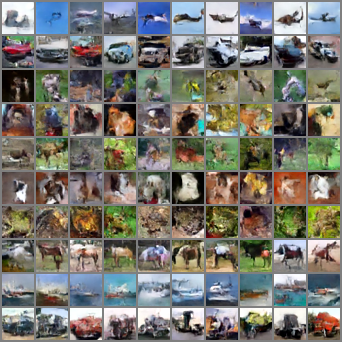


Epoch 20


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20, iteration: 0, loss: 0.12575
Epoch: 20, iteration: 50, loss: 0.119106
Epoch: 20, iteration: 100, loss: 0.123112
Epoch: 20, iteration: 150, loss: 0.127657
Epoch: 20, iteration: 200, loss: 0.129546
Epoch: 20, iteration: 250, loss: 0.120729
Epoch: 20, iteration: 300, loss: 0.136018
Epoch: 20, iteration: 350, loss: 0.120746
Epoch: 20, iteration: 400, loss: 0.123172
Epoch: 20, iteration: 450, loss: 0.118939
Epoch 21


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21, iteration: 0, loss: 0.120116
Epoch: 21, iteration: 50, loss: 0.124988
Epoch: 21, iteration: 100, loss: 0.115019
Epoch: 21, iteration: 150, loss: 0.129294
Epoch: 21, iteration: 200, loss: 0.115536
Epoch: 21, iteration: 250, loss: 0.137636
Epoch: 21, iteration: 300, loss: 0.12055
Epoch: 21, iteration: 350, loss: 0.119699
Epoch: 21, iteration: 400, loss: 0.126666
Epoch: 21, iteration: 450, loss: 0.136247
Epoch 22


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22, iteration: 0, loss: 0.125006
Epoch: 22, iteration: 50, loss: 0.134056
Epoch: 22, iteration: 100, loss: 0.128891
Epoch: 22, iteration: 150, loss: 0.137008
Epoch: 22, iteration: 200, loss: 0.123996
Epoch: 22, iteration: 250, loss: 0.117195
Epoch: 22, iteration: 300, loss: 0.11877
Epoch: 22, iteration: 350, loss: 0.127624
Epoch: 22, iteration: 400, loss: 0.110058
Epoch: 22, iteration: 450, loss: 0.133602
Epoch 23


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23, iteration: 0, loss: 0.129686
Epoch: 23, iteration: 50, loss: 0.120005
Epoch: 23, iteration: 100, loss: 0.132835
Epoch: 23, iteration: 150, loss: 0.118
Epoch: 23, iteration: 200, loss: 0.120838
Epoch: 23, iteration: 250, loss: 0.127472
Epoch: 23, iteration: 300, loss: 0.126172
Epoch: 23, iteration: 350, loss: 0.119838
Epoch: 23, iteration: 400, loss: 0.131677
Epoch: 23, iteration: 450, loss: 0.114865
Epoch 24


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24, iteration: 0, loss: 0.12303
Epoch: 24, iteration: 50, loss: 0.120179
Epoch: 24, iteration: 100, loss: 0.124503
Epoch: 24, iteration: 150, loss: 0.133006
Epoch: 24, iteration: 200, loss: 0.11966
Epoch: 24, iteration: 250, loss: 0.120154
Epoch: 24, iteration: 300, loss: 0.128386
Epoch: 24, iteration: 350, loss: 0.126639
Epoch: 24, iteration: 400, loss: 0.126337
Epoch: 24, iteration: 450, loss: 0.115925

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 25, loss: 0.117816

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

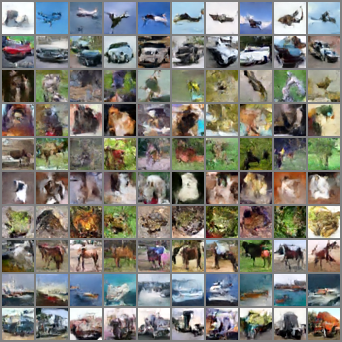


Epoch 25


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25, iteration: 0, loss: 0.111696
Epoch: 25, iteration: 50, loss: 0.128642
Epoch: 25, iteration: 100, loss: 0.133812
Epoch: 25, iteration: 150, loss: 0.133166
Epoch: 25, iteration: 200, loss: 0.117146
Epoch: 25, iteration: 250, loss: 0.123922
Epoch: 25, iteration: 300, loss: 0.129229
Epoch: 25, iteration: 350, loss: 0.113455
Epoch: 25, iteration: 400, loss: 0.121207
Epoch: 25, iteration: 450, loss: 0.12679
Epoch 26


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26, iteration: 0, loss: 0.122508
Epoch: 26, iteration: 50, loss: 0.124456
Epoch: 26, iteration: 100, loss: 0.127175
Epoch: 26, iteration: 150, loss: 0.123597
Epoch: 26, iteration: 200, loss: 0.129079
Epoch: 26, iteration: 250, loss: 0.118557
Epoch: 26, iteration: 300, loss: 0.131951
Epoch: 26, iteration: 350, loss: 0.127197
Epoch: 26, iteration: 400, loss: 0.131396
Epoch: 26, iteration: 450, loss: 0.119345
Epoch 27


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27, iteration: 0, loss: 0.128356
Epoch: 27, iteration: 50, loss: 0.126158
Epoch: 27, iteration: 100, loss: 0.121091
Epoch: 27, iteration: 150, loss: 0.1221
Epoch: 27, iteration: 200, loss: 0.118647
Epoch: 27, iteration: 250, loss: 0.11719
Epoch: 27, iteration: 300, loss: 0.123123
Epoch: 27, iteration: 350, loss: 0.129558
Epoch: 27, iteration: 400, loss: 0.131217
Epoch: 27, iteration: 450, loss: 0.128503
Epoch 28


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28, iteration: 0, loss: 0.121734
Epoch: 28, iteration: 50, loss: 0.128681
Epoch: 28, iteration: 100, loss: 0.119418
Epoch: 28, iteration: 150, loss: 0.126531
Epoch: 28, iteration: 200, loss: 0.120574
Epoch: 28, iteration: 250, loss: 0.117194
Epoch: 28, iteration: 300, loss: 0.124029
Epoch: 28, iteration: 350, loss: 0.120596
Epoch: 28, iteration: 400, loss: 0.113333
Epoch: 28, iteration: 450, loss: 0.118132
Epoch 29


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29, iteration: 0, loss: 0.118525
Epoch: 29, iteration: 50, loss: 0.122878
Epoch: 29, iteration: 100, loss: 0.120073
Epoch: 29, iteration: 150, loss: 0.133393
Epoch: 29, iteration: 200, loss: 0.129387
Epoch: 29, iteration: 250, loss: 0.11948
Epoch: 29, iteration: 300, loss: 0.130325
Epoch: 29, iteration: 350, loss: 0.113733
Epoch: 29, iteration: 400, loss: 0.12191
Epoch: 29, iteration: 450, loss: 0.126152

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 30, loss: 0.117027

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

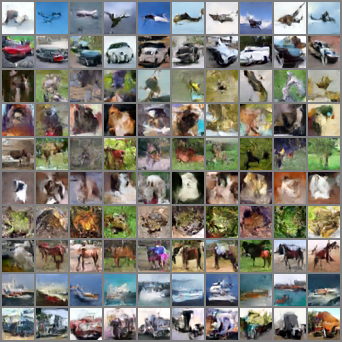


Epoch 30


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 30, iteration: 0, loss: 0.127336
Epoch: 30, iteration: 50, loss: 0.117211
Epoch: 30, iteration: 100, loss: 0.128806
Epoch: 30, iteration: 150, loss: 0.120629
Epoch: 30, iteration: 200, loss: 0.126356
Epoch: 30, iteration: 250, loss: 0.118027
Epoch: 30, iteration: 300, loss: 0.118552
Epoch: 30, iteration: 350, loss: 0.124214
Epoch: 30, iteration: 400, loss: 0.124221
Epoch: 30, iteration: 450, loss: 0.130089
Epoch 31


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 31, iteration: 0, loss: 0.123754
Epoch: 31, iteration: 50, loss: 0.12949
Epoch: 31, iteration: 100, loss: 0.119087
Epoch: 31, iteration: 150, loss: 0.121143
Epoch: 31, iteration: 200, loss: 0.117328
Epoch: 31, iteration: 250, loss: 0.125952
Epoch: 31, iteration: 300, loss: 0.128413
Epoch: 31, iteration: 350, loss: 0.13019
Epoch: 31, iteration: 400, loss: 0.123009
Epoch: 31, iteration: 450, loss: 0.129862
Epoch 32


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 32, iteration: 0, loss: 0.113171
Epoch: 32, iteration: 50, loss: 0.1239
Epoch: 32, iteration: 100, loss: 0.115824
Epoch: 32, iteration: 150, loss: 0.115389
Epoch: 32, iteration: 200, loss: 0.121451
Epoch: 32, iteration: 250, loss: 0.121659
Epoch: 32, iteration: 300, loss: 0.125685
Epoch: 32, iteration: 350, loss: 0.121902
Epoch: 32, iteration: 400, loss: 0.1198
Epoch: 32, iteration: 450, loss: 0.122458
Epoch 33


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 33, iteration: 0, loss: 0.126082
Epoch: 33, iteration: 50, loss: 0.114456
Epoch: 33, iteration: 100, loss: 0.134189
Epoch: 33, iteration: 150, loss: 0.114379
Epoch: 33, iteration: 200, loss: 0.124971
Epoch: 33, iteration: 250, loss: 0.123635
Epoch: 33, iteration: 300, loss: 0.120994
Epoch: 33, iteration: 350, loss: 0.113366
Epoch: 33, iteration: 400, loss: 0.121294
Epoch: 33, iteration: 450, loss: 0.127809
Epoch 34


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 34, iteration: 0, loss: 0.123308
Epoch: 34, iteration: 50, loss: 0.126425
Epoch: 34, iteration: 100, loss: 0.124185
Epoch: 34, iteration: 150, loss: 0.124963
Epoch: 34, iteration: 200, loss: 0.119854
Epoch: 34, iteration: 250, loss: 0.118395
Epoch: 34, iteration: 300, loss: 0.116315
Epoch: 34, iteration: 350, loss: 0.121873
Epoch: 34, iteration: 400, loss: 0.119429
Epoch: 34, iteration: 450, loss: 0.132165

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 35, loss: 0.116387

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

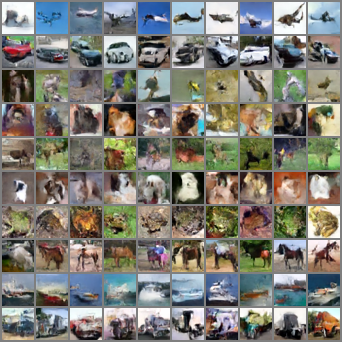


Epoch 35


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 35, iteration: 0, loss: 0.125954
Epoch: 35, iteration: 50, loss: 0.129871
Epoch: 35, iteration: 100, loss: 0.116717
Epoch: 35, iteration: 150, loss: 0.114324
Epoch: 35, iteration: 200, loss: 0.108219
Epoch: 35, iteration: 250, loss: 0.110374
Epoch: 35, iteration: 300, loss: 0.120146
Epoch: 35, iteration: 350, loss: 0.126377
Epoch: 35, iteration: 400, loss: 0.123198
Epoch: 35, iteration: 450, loss: 0.123121
Epoch 36


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 36, iteration: 0, loss: 0.125973
Epoch: 36, iteration: 50, loss: 0.11742
Epoch: 36, iteration: 100, loss: 0.121816
Epoch: 36, iteration: 150, loss: 0.124711
Epoch: 36, iteration: 200, loss: 0.134014
Epoch: 36, iteration: 250, loss: 0.11707
Epoch: 36, iteration: 300, loss: 0.12061
Epoch: 36, iteration: 350, loss: 0.118451
Epoch: 36, iteration: 400, loss: 0.122665
Epoch: 36, iteration: 450, loss: 0.119204
Epoch 37


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 37, iteration: 0, loss: 0.114141
Epoch: 37, iteration: 50, loss: 0.130409
Epoch: 37, iteration: 100, loss: 0.120183
Epoch: 37, iteration: 150, loss: 0.12997
Epoch: 37, iteration: 200, loss: 0.125696
Epoch: 37, iteration: 250, loss: 0.128186
Epoch: 37, iteration: 300, loss: 0.115282
Epoch: 37, iteration: 350, loss: 0.123886
Epoch: 37, iteration: 400, loss: 0.121288
Epoch: 37, iteration: 450, loss: 0.124834
Epoch 38


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 38, iteration: 0, loss: 0.113496
Epoch: 38, iteration: 50, loss: 0.126379
Epoch: 38, iteration: 100, loss: 0.128212
Epoch: 38, iteration: 150, loss: 0.122427
Epoch: 38, iteration: 200, loss: 0.114135
Epoch: 38, iteration: 250, loss: 0.111354
Epoch: 38, iteration: 300, loss: 0.109006
Epoch: 38, iteration: 350, loss: 0.124067
Epoch: 38, iteration: 400, loss: 0.119415
Epoch: 38, iteration: 450, loss: 0.118806
Epoch 39


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 39, iteration: 0, loss: 0.12513
Epoch: 39, iteration: 50, loss: 0.123463
Epoch: 39, iteration: 100, loss: 0.118415
Epoch: 39, iteration: 150, loss: 0.113421
Epoch: 39, iteration: 200, loss: 0.124063
Epoch: 39, iteration: 250, loss: 0.122183
Epoch: 39, iteration: 300, loss: 0.113791
Epoch: 39, iteration: 350, loss: 0.119894
Epoch: 39, iteration: 400, loss: 0.121898
Epoch: 39, iteration: 450, loss: 0.119955

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 40, loss: 0.11589

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

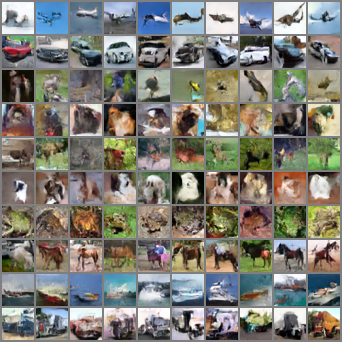


Epoch 40


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 40, iteration: 0, loss: 0.118766
Epoch: 40, iteration: 50, loss: 0.118645
Epoch: 40, iteration: 100, loss: 0.125651
Epoch: 40, iteration: 150, loss: 0.11742
Epoch: 40, iteration: 200, loss: 0.114818
Epoch: 40, iteration: 250, loss: 0.131992
Epoch: 40, iteration: 300, loss: 0.12446
Epoch: 40, iteration: 350, loss: 0.133197
Epoch: 40, iteration: 400, loss: 0.127368
Epoch: 40, iteration: 450, loss: 0.120322
Epoch 41


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 41, iteration: 0, loss: 0.126414
Epoch: 41, iteration: 50, loss: 0.125585
Epoch: 41, iteration: 100, loss: 0.119964
Epoch: 41, iteration: 150, loss: 0.122966
Epoch: 41, iteration: 200, loss: 0.125009
Epoch: 41, iteration: 250, loss: 0.119006
Epoch: 41, iteration: 300, loss: 0.133232
Epoch: 41, iteration: 350, loss: 0.115813
Epoch: 41, iteration: 400, loss: 0.112357
Epoch: 41, iteration: 450, loss: 0.121699
Epoch 42


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 42, iteration: 0, loss: 0.110512
Epoch: 42, iteration: 50, loss: 0.122126
Epoch: 42, iteration: 100, loss: 0.12697
Epoch: 42, iteration: 150, loss: 0.114807
Epoch: 42, iteration: 200, loss: 0.12752
Epoch: 42, iteration: 250, loss: 0.115052
Epoch: 42, iteration: 300, loss: 0.125454
Epoch: 42, iteration: 350, loss: 0.110476
Epoch: 42, iteration: 400, loss: 0.11693
Epoch: 42, iteration: 450, loss: 0.122025
Epoch 43


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 43, iteration: 0, loss: 0.135805
Epoch: 43, iteration: 50, loss: 0.124417
Epoch: 43, iteration: 100, loss: 0.122392
Epoch: 43, iteration: 150, loss: 0.111158
Epoch: 43, iteration: 200, loss: 0.112325
Epoch: 43, iteration: 250, loss: 0.12822
Epoch: 43, iteration: 300, loss: 0.115582
Epoch: 43, iteration: 350, loss: 0.122154
Epoch: 43, iteration: 400, loss: 0.124116
Epoch: 43, iteration: 450, loss: 0.128345
Epoch 44


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 44, iteration: 0, loss: 0.115353
Epoch: 44, iteration: 50, loss: 0.11472
Epoch: 44, iteration: 100, loss: 0.112553
Epoch: 44, iteration: 150, loss: 0.122769
Epoch: 44, iteration: 200, loss: 0.109712
Epoch: 44, iteration: 250, loss: 0.120792
Epoch: 44, iteration: 300, loss: 0.11804
Epoch: 44, iteration: 350, loss: 0.128337
Epoch: 44, iteration: 400, loss: 0.118319
Epoch: 44, iteration: 450, loss: 0.113135

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 45, loss: 0.115469

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

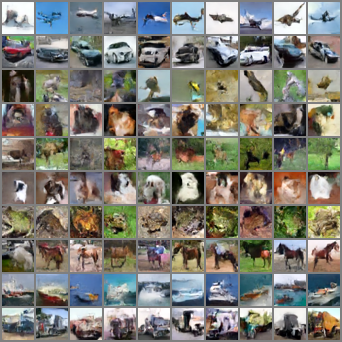


Epoch 45


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 45, iteration: 0, loss: 0.115734
Epoch: 45, iteration: 50, loss: 0.118308
Epoch: 45, iteration: 100, loss: 0.121779
Epoch: 45, iteration: 150, loss: 0.113853
Epoch: 45, iteration: 200, loss: 0.117085
Epoch: 45, iteration: 250, loss: 0.128819
Epoch: 45, iteration: 300, loss: 0.115005
Epoch: 45, iteration: 350, loss: 0.120442
Epoch: 45, iteration: 400, loss: 0.115045
Epoch: 45, iteration: 450, loss: 0.121987
Epoch 46


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 46, iteration: 0, loss: 0.121224
Epoch: 46, iteration: 50, loss: 0.119447
Epoch: 46, iteration: 100, loss: 0.128575
Epoch: 46, iteration: 150, loss: 0.126915
Epoch: 46, iteration: 200, loss: 0.116681
Epoch: 46, iteration: 250, loss: 0.112011
Epoch: 46, iteration: 300, loss: 0.127452
Epoch: 46, iteration: 350, loss: 0.117679
Epoch: 46, iteration: 400, loss: 0.117056
Epoch: 46, iteration: 450, loss: 0.120615
Epoch 47


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 47, iteration: 0, loss: 0.123784
Epoch: 47, iteration: 50, loss: 0.124833
Epoch: 47, iteration: 100, loss: 0.121264
Epoch: 47, iteration: 150, loss: 0.120291
Epoch: 47, iteration: 200, loss: 0.114867
Epoch: 47, iteration: 250, loss: 0.114205
Epoch: 47, iteration: 300, loss: 0.122727
Epoch: 47, iteration: 350, loss: 0.120182
Epoch: 47, iteration: 400, loss: 0.115056
Epoch: 47, iteration: 450, loss: 0.11868
Epoch 48


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 48, iteration: 0, loss: 0.121108
Epoch: 48, iteration: 50, loss: 0.112331
Epoch: 48, iteration: 100, loss: 0.105662
Epoch: 48, iteration: 150, loss: 0.126225
Epoch: 48, iteration: 200, loss: 0.120936
Epoch: 48, iteration: 250, loss: 0.123188
Epoch: 48, iteration: 300, loss: 0.133189
Epoch: 48, iteration: 350, loss: 0.126024
Epoch: 48, iteration: 400, loss: 0.132556
Epoch: 48, iteration: 450, loss: 0.117537
Epoch 49


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 49, iteration: 0, loss: 0.118812
Epoch: 49, iteration: 50, loss: 0.1232
Epoch: 49, iteration: 100, loss: 0.12334
Epoch: 49, iteration: 150, loss: 0.117182
Epoch: 49, iteration: 200, loss: 0.123803
Epoch: 49, iteration: 250, loss: 0.120533
Epoch: 49, iteration: 300, loss: 0.126145
Epoch: 49, iteration: 350, loss: 0.109081
Epoch: 49, iteration: 400, loss: 0.11913
Epoch: 49, iteration: 450, loss: 0.119724

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 50, loss: 0.115115

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

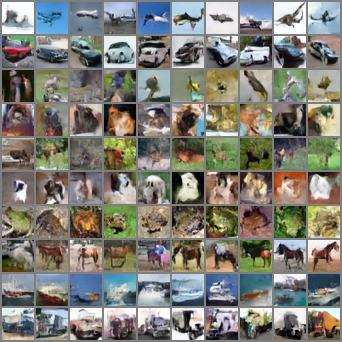


Epoch 50


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 50, iteration: 0, loss: 0.125446
Epoch: 50, iteration: 50, loss: 0.118934
Epoch: 50, iteration: 100, loss: 0.114925
Epoch: 50, iteration: 150, loss: 0.129508
Epoch: 50, iteration: 200, loss: 0.11686
Epoch: 50, iteration: 250, loss: 0.125664
Epoch: 50, iteration: 300, loss: 0.117958
Epoch: 50, iteration: 350, loss: 0.114974
Epoch: 50, iteration: 400, loss: 0.12561
Epoch: 50, iteration: 450, loss: 0.129808
Epoch 51


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 51, iteration: 0, loss: 0.12711
Epoch: 51, iteration: 50, loss: 0.130026
Epoch: 51, iteration: 100, loss: 0.115275
Epoch: 51, iteration: 150, loss: 0.113584
Epoch: 51, iteration: 200, loss: 0.115656
Epoch: 51, iteration: 250, loss: 0.118833
Epoch: 51, iteration: 300, loss: 0.128651
Epoch: 51, iteration: 350, loss: 0.120597
Epoch: 51, iteration: 400, loss: 0.125482
Epoch: 51, iteration: 450, loss: 0.122227
Epoch 52


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 52, iteration: 0, loss: 0.116251
Epoch: 52, iteration: 50, loss: 0.112161
Epoch: 52, iteration: 100, loss: 0.121112
Epoch: 52, iteration: 150, loss: 0.116627
Epoch: 52, iteration: 200, loss: 0.120857
Epoch: 52, iteration: 250, loss: 0.11599
Epoch: 52, iteration: 300, loss: 0.132772
Epoch: 52, iteration: 350, loss: 0.128897
Epoch: 52, iteration: 400, loss: 0.118212
Epoch: 52, iteration: 450, loss: 0.109179
Epoch 53


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 53, iteration: 0, loss: 0.106702
Epoch: 53, iteration: 50, loss: 0.110684
Epoch: 53, iteration: 100, loss: 0.117357
Epoch: 53, iteration: 150, loss: 0.117416
Epoch: 53, iteration: 200, loss: 0.11162
Epoch: 53, iteration: 250, loss: 0.121264
Epoch: 53, iteration: 300, loss: 0.115144
Epoch: 53, iteration: 350, loss: 0.11884
Epoch: 53, iteration: 400, loss: 0.113677
Epoch: 53, iteration: 450, loss: 0.126361
Epoch 54


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 54, iteration: 0, loss: 0.114782
Epoch: 54, iteration: 50, loss: 0.128372
Epoch: 54, iteration: 100, loss: 0.120864
Epoch: 54, iteration: 150, loss: 0.131868
Epoch: 54, iteration: 200, loss: 0.118353
Epoch: 54, iteration: 250, loss: 0.106374
Epoch: 54, iteration: 300, loss: 0.108466
Epoch: 54, iteration: 350, loss: 0.119353
Epoch: 54, iteration: 400, loss: 0.124451
Epoch: 54, iteration: 450, loss: 0.125786

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 55, loss: 0.114829

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

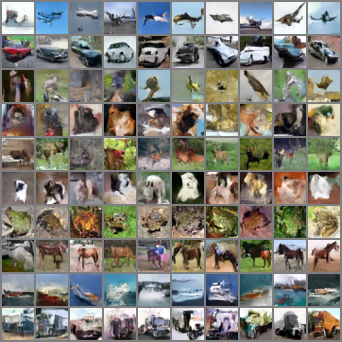


Epoch 55


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 55, iteration: 0, loss: 0.121842
Epoch: 55, iteration: 50, loss: 0.119417


In [20]:
# Actually train the model

ema_decay = 0.999

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.

# Classifier-free guidance scale (0 is unconditional, 1 is conditional)
guidance_scale = 2.

def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    alphas, sigmas = get_alphas_sigmas(t)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Drop out the class on 20% of the examples
    to_drop = torch.rand(classes.shape, device=classes.device).le(0.2)
    classes_drop = torch.where(to_drop, -torch.ones_like(classes), classes) # drop 则把标签设为-1

    # Compute the model output and the loss.
    with torch.cuda.amp.autocast():
        v = model(noised_reals, t, classes_drop)
        return F.mse_loss(v, targets)


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'cifar_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


try:
    val()
    demo()
    while True:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 5 == 0:
            val()
            demo()
        save()
except KeyboardInterrupt:
    pass
